![logo](images/logo.png)

En primer lugar vamos a leer un dataset con eventos de cada uno de los usos finales del agua.

Este dataset contiene eventos pertenecientes a estos 6 usos finales:

* Grifos
* Cisternas
* Duchas
* Fugas
* Lavadora
* Lavavajillas

El fichero está en format CSV, a continuación se suminastra una función que permite cargarla.


In [63]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import Normalizer

np.random.seed(12)

def ReadEvents(file):
    data = np.loadtxt(file,skiprows=1,delimiter=';',usecols=range(0,37))
    labels = np.loadtxt(file,skiprows=1,delimiter=';',usecols=(37,),dtype='str')
    
    (nSamples,nFeatures)=data.shape
    randomPermutation = np.random.permutation(nSamples)
    data=data[randomPermutation,:]
    labels=labels[randomPermutation]
    le = preprocessing.LabelEncoder()
    le.fit(np.unique(labels))
    labels = le.transform(labels)
    return data,labels,le

(data,labels,le) = ReadEvents('dataset/dataset_eventos.csv')




Vamos a comprobar la dificultad del problema al que nos enfrentamos. Para ello vamos a utilizar el algoritmo de visualización t-SNE.

Es un algoritmo que permite reducir datasets con un número elevado de dimensiones a únicamente dos dimensiones, con lo que se puede visualizar cómo de complejo es clasificar un dataset.

En la siguiente imágen se puede ver un ejemplo del algoritmo t-SNE con la base de datos MNIST:

<img src="images/tsne-mnist.png" width="300">

Vamos a ejecutar el algoritmo sobre un conjunto de variables de nuestro dataset para ver la dificultad de nuestro problema.

Podrá observar que la principal dificultad radica en el consumo de grifos, que debido a su gran variabilidad puede confundirse con cualquier otro.


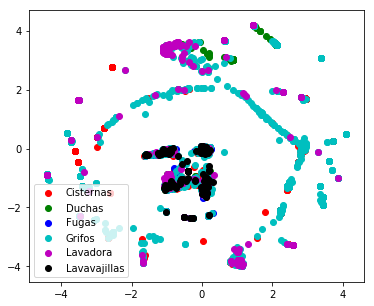

In [65]:
from sklearn.preprocessing import Normalizer

(data,labels,le) = ReadEvents('dataset/dataset_eventos.csv')

normalizador = Normalizer()
data = data[:,[2,9,0,6,4,10,1,7,3]]
data=normalizador.fit_transform(data)

tsne = TSNE(n_components=2, learning_rate=0.1)

X_2d = tsne.fit_transform(data[0:3000,:])

plt.figure(figsize=(6, 5))

colors = 'r', 'g', 'b', 'c', 'm', 'k'
for i, c, label in zip(target_ids, colors, class_names):
    plt.scatter(X_2d[labels[0:3000] == i, 0], X_2d[labels[0:3000] == i, 1], c=c, label=label)
plt.legend()
plt.show()


---
#### ALGORITMO 1.MODELO LINEAL, Regresión logística
---

En primer lugar vamos a probar el clasificador conocido como regresión logística. Es un modelo lineal que se encuentra implementado en la librería sklearn.

<img src="images/linear.jpg" width="350" />

Su principal hiperparámetro es el asociado a la regularización (parámetro C en la inicialización).

La función LogistricRegressionCV se encarga de hacer la validación cruzada por nosotros:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html

Siga los siguientes pasos:

* Entrene el algoritmo probando los valores C=10^n donde n puede tomar los valores {-4,-3,-2,-1,0,1,2,3,4}
* Obtenga el accuracy sobre el conjunto de test.


In [66]:


from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

# Vamos a leer los eventos del fichero
(data,labels,le) = ReadEvents('dataset/dataset_eventos.csv')

##########################################################################################
# Divida el conjunto de datos en un conjunto de entrenamiento y test.
# Deje el 70% de los datos en el conjunto de entrenamiento y el 30% restante en el de test
# Puede hacer uso de la función train_test_split de sklearn
##########################################################################################

x_train, x_test, y_train, y_test = train_test_split(data,labels, test_size=0.3)

##########################################################################################
# Utilice el algoritmo LogisticRegressionCV de sklearn para hacer la validación cruzada
# del parámetro C del algoritmo. Puede encontrar aquí información sobre la función 
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
##########################################################################################

cs=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

modelo = LogisticRegressionCV(cv=5, Cs=cs, multi_class='multinomial').fit(x_train, y_train)

###########################################################################################
# Utilice el modelo lineal para clasificar el conjunto de test y obtenga la accuracy.
###########################################################################################

preds = modelo.predict(x_test)
accuracy = accuracy_score(y_test,preds) 

print("Accuracy",accuracy)



Accuracy 0.49059466019417475


---
#### ALGORITMO 2.MÉTODOS DE NÚCLEO, SVM No lineal
---

Finalmente vamos a probar un modelo no lineal conocido como máquinas de vectores soporte (SVMs), vamos a utilizar como función de kernel una función de base radial ('rbf'). 

<img src="images/svm.png" width="350" />

También se encuentra en la librería sklearn:

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

En este caso tenemos dos hiperparámetros a validar. El parámetro de regularización (llamado C) y la anchura de la función de kernel rbf (llamado gamma). 

La función GridSearchCV nos facilitará la validación cruzada:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Siga los siguientes pasos:

1. Obtenga este parámetro por validaión cruzada probando los valores C=10^n donde n puede tomar los valores {-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6} y gamma=10^n donde n puede tomar los valores {-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6} 

2. Una vez conozca los mejores parámetros, entrene con estos valores y obtenga el accuracy sobre el conjunto de test.


In [69]:

from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


(data,labels,le) = ReadEvents('dataset/dataset_eventos.csv')
x_train, x_test, y_train, y_test = train_test_split(data,labels, test_size=0.3)



x_train=x_train[:,[2,9,0,6,4,10,1,7,3]]
x_test=x_test[:,[2,9,0,6,4,10,1,7,3]]

######################################################################################
# Nomalice el conjunto de datos para que las vairables tengan media 0 y varianza 1
# Puede hacer uso de la función Normalizer de sklearn.
#######################################################################################
normalizador = Normalizer()
x_train=normalizador.fit_transform(x_train)
x_test=normalizador.transform(x_test)


######################################################################################
# Hago uso de la función GridSearchCV para entrenar una SVM
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# Explore los valores de C=1, 10, 100 y gamma=1,10,100 
######################################################################################

Cs = [1, 10, 100]
gammas = [1,10,100]
param_grid = {'C': Cs, 'gamma' : gammas}
svm_classifier = GridSearchCV(svm.SVC(kernel='rbf',cache_size=4000), param_grid, cv=StratifiedKFold(n_splits=5),n_jobs=4,verbose=2)
svm_classifier.fit(x_train, y_train)

###########################################################################################
# Utilice la SVM para clasificar el conjunto de test y obtenga la accuracy.
###########################################################################################


predictions=svm_classifier.predict(x_test)
Accuracy = accuracy_score(predictions,y_test)

print("Final Accuracy:", Accuracy)

###############################################################################################
# No se observa mejora respecto al modelo lineal. El motivo es que a la SVM le afectan muy negativamente
# varaibles que no aportan información.
# Repita el ejercicio seleccionando las variables (columnas) [2,9,0,6,4,10,1,7,3]
################################################################################################


                        


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=1, gamma=1 ....................................................
[CV] C=1, gamma=1 ....................................................
[CV] C=1, gamma=1 ....................................................
[CV] C=1, gamma=1 ....................................................
[CV] ..................................... C=1, gamma=1, total=   1.2s
[CV] ..................................... C=1, gamma=1, total=   1.2s
[CV] C=1, gamma=1 ....................................................
[CV] C=1, gamma=10 ...................................................
[CV] ..................................... C=1, gamma=1, total=   1.2s
[CV] C=1, gamma=10 ...................................................
[CV] ..................................... C=1, gamma=1, total=   1.2s
[CV] C=1, gamma=10 ...................................................
[CV] .................................... C=1, gamma=10, total=   1.1s
[CV] C=1, gamma=1

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   16.2s


[CV] ................................... C=100, gamma=1, total=   1.2s
[CV] C=100, gamma=10 .................................................
[CV] .................................. C=100, gamma=10, total=   1.5s
[CV] C=100, gamma=10 .................................................
[CV] .................................. C=100, gamma=10, total=   1.5s
[CV] C=100, gamma=100 ................................................
[CV] .................................. C=100, gamma=10, total=   1.8s
[CV] C=100, gamma=100 ................................................
[CV] .................................. C=100, gamma=10, total=   1.7s
[CV] C=100, gamma=100 ................................................
[CV] .................................. C=100, gamma=10, total=   1.5s
[CV] C=100, gamma=100 ................................................
[CV] ................................. C=100, gamma=100, total=   1.7s
[CV] C=100, gamma=100 ................................................
[CV] .

[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:   23.0s finished


Final Accuracy: 0.6535194174757282


---
#### ALGORITMO 3. REDES NEURONALES, Perceptrón Multicapa
---




In [53]:

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense, Activation
from keras.models import Sequential
from keras.optimizers import Nadam
from sklearn.preprocessing import MinMaxScaler


(data,labels,le) = ReadEvents('dataset/dataset_eventos.csv')
x_train, x_test, y_train, y_test = train_test_split(data,labels, test_size=0.3)

normalizer = MinMaxScaler(feature_range=(0, 0.1))
x_train=normalizer.fit_transform(x_train)
x_test=normalizer.transform(x_test)


lrates = [0.001,0.01,0.1]
   

BestAccuracy=-1.0
BestC = -1
BestG = -1

Xcvtr, Xcvtst, Ycvtr, Ycvtst = train_test_split(x_train,y_train, test_size=0.3)

Ycvtr = np.eye(6)[np.int_(Ycvtr)]
Ycvtst = np.eye(6)[np.int_(Ycvtst)]
y_test = np.eye(6)[np.int_(y_test)]

for l in lrates:
    print("Training parameters: lrate=",l)
    n_epoch = 10
    batch_size = 16
    input_dim = 37
    hidden = 300
    output = 6  
    #CREATING THE NEURAL NETWORK
    model = Sequential()
    model.add(Dense(hidden,input_dim=input_dim,init='lecun_uniform',activation='relu'))
    model.add(Dense(output_dim=6,init='lecun_uniform'))
    model.add(Activation('softmax'))
    decay = l/n_epoch

    nadam = Nadam(lr=l)
    model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
    model.fit(Xcvtr, Ycvtr, nb_epoch=n_epoch, shuffle=True, batch_size=batch_size)
            
    predictions = model.predict(Xcvtst)
    predictions =np.argmax(predictions,axis=1)
    labelsTest = np.argmax(Ycvtst,axis= 1)
    Accuracy = np.float((predictions==labelsTest).sum())/Ycvtst.shape[0]
            
            
    if(Accuracy> BestAccuracy):
        BestAccuracy = Accuracy
        BestLRate = l

                

    print("Right Now Best Accuracy CV:",BestAccuracy, "LRate:", BestLRate)
print("Best Accuracy CV:",BestAccuracy, "LRate:", BestLRate)


Training parameters: lrate= 0.001
Epoch 1/10
5381/5381 [==============================] - 2s 411us/step - loss: 1.4308 - acc: 0.4689
Epoch 2/10
5381/5381 [==============================] - 0s 87us/step - loss: 1.2553 - acc: 0.4962
Epoch 3/10
5381/5381 [==============================] - 0s 87us/step - loss: 1.1566 - acc: 0.5133
Epoch 4/10
5381/5381 [==============================] - 0s 88us/step - loss: 1.0983 - acc: 0.5261
Epoch 5/10
5381/5381 [==============================] - 0s 87us/step - loss: 1.0588 - acc: 0.5386
Epoch 6/10
5381/5381 [==============================] - 0s 87us/step - loss: 1.0293 - acc: 0.5544
Epoch 7/10
5381/5381 [==============================] - 0s 88us/step - loss: 1.0029 - acc: 0.5672
Epoch 8/10
5381/5381 [==============================] - 0s 87us/step - loss: 0.9823 - acc: 0.5763
Epoch 9/10
5381/5381 [==============================] - 0s 88us/step - loss: 0.9634 - acc: 0.5884
Epoch 10/10
5381/5381 [==============================] - 0s 87us/step - loss: 0.946

---
#### ALGORITMO 4. ÁRBOLES, XGBOOST
---

En segundo lugar vamos a probar un modelo lineal conocido como árbol de decisión. Lo puedes encontrar implementado en lal ibrería sklearn.

<img src="images\tree.png" width="350" />

Su principal hiperparámetro es la profundidad del árbol (parámetro max_depth en la inicialización):

```python
from sklearn.tree import DecisionTreeClassifier

# C es el parámetro de regularización:
clf = DecisionTreeClassifier(max_depth=5)

# Con la función fit se entrena
clf.fit(Xtrain, ytrain)

# Con la función predict se obtienen las etiquetas de un nuevo conjunto de datos
clf.predict(Xtest)

```
Siga los siguientes pasos:

1. Obtenga la profundidad por validaión cruzada probando los valores del 1 al 10


2. Obtenga el accuracy de validación para cada uno de los valores del hiperparámetro.

3. Entrene con todo el conjunto de entrenamiento para el mejor valor de validación de C y muestre sobre el conjunto de test el accuracy y la matriz de confusión.


In [43]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier


(data,labels,le) = ReadEvents('dataset/dataset_eventos.csv')
x_train, x_test, y_train, y_test = train_test_split(data,labels, test_size=0.3)

x_train=x_train[:,[2,9,0,6,4,10,1,7,3]]
x_test=x_test[:,[2,9,0,6,4,10,1,7,3]]

normalizador = Normalizer()
x_train=normalizador.fit_transform(x_train)
x_test=normalizador.transform(x_test)


depths=np.array([7,11])
   

BestAccuracy=-1.0
BestC = -1
BestG = -1

Xcvtr, Xcvtst, Ycvtr, Ycvtst = train_test_split(x_train,y_train, test_size=0.3)

    
BestAccuracy=-1.0

    
for depth in depths:
        
        Accuracy = 0.0
        print("Training parameters: depth=",depth)
            
        xgbclassifier=XGBClassifier(max_depth=depth, n_estimators=100, learning_rate=0.05,subsample=0.9,verbose=2)
        xgbclassifier.fit(Xcvtr,Ycvtr)

        predictions=xgbclassifier.predict(Xcvtst)
        Accuracy = accuracy_score(predictions,Ycvtst)

        if(Accuracy> BestAccuracy):
            BestAccuracy = Accuracy
            BestDepth = depth
                

        print("Right Now Best Accuracy CV:",BestAccuracy, "Depth:", BestDepth)


Training parameters: depth= 7
Right Now Best Accuracy CV: 0.7000433463372345 Depth: 7
Training parameters: depth= 11
Right Now Best Accuracy CV: 0.7013437364542696 Depth: 11


In [45]:
XGBClassifier = XGBClassifier(max_depth=BestDepth, n_estimators=100, learning_rate=0.05,subsample=0.9,verbose=2)
XGBClassifier.fit(x_train,y_train)

predictions=XGBClassifier.predict(x_test)
Accuracy = accuracy_score(predictions,y_test)

print("Final Accuracy:",Accuracy)

Final Accuracy: 0.6808252427184466
